In [87]:
'''
loading libs
'''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [88]:
'''
loading images
'''
nevus_filepath = 'data/0/'
melanoma_filepath = 'data/1/'

nevus_files = [f for f in os.listdir(nevus_filepath) if os.path.isfile(nevus_filepath+f)]
melanoma_files = [f for f in os.listdir(melanoma_filepath) if os.path.isfile(melanoma_filepath+f)]
# sort filenames
nevus_files = sorted(nevus_files)
melanoma_files = sorted(melanoma_files)

N = 150
nevus_imgs = [plt.imread(os.path.join(nevus_filepath, nevus_files[i])) for i in range(N)]
melanoma_imgs = [plt.imread(os.path.join(melanoma_filepath, melanoma_files[i])) for i in range(N)]

# resize
nevus_imgs = [cv2.resize(img,(256,256)) for img in nevus_imgs]
melanoma_imgs = [cv2.resize(img,(256,256)) for img in melanoma_imgs]

nevus_imgs = np.array(nevus_imgs)
melanoma_imgs = np.array(melanoma_imgs)

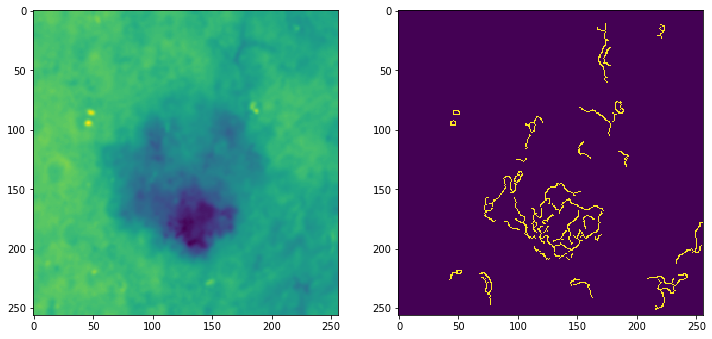

In [173]:
index = 2
img = nevus_imgs[index]

n = np.min(img.shape)*6 * 0.005
n = int(np.floor(n))
# print(n)

nani = cv2.GaussianBlur(img,(n,n),0)

# clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3))
# nani = clahe.apply(nani)

edges = cv2.Canny(nani,10,50)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(nani)
ax[1].imshow(edges, vmax=255,vmin=0)
# fig.colorbar(im)

In [4]:
# Define clustering of colors in image
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

def cluster_image(img, n_colors):
    if img.max() > 1:
        img = img / 255
        
    image_array = img.reshape(img.shape[0]*img.shape[1],1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    return recreate_image(kmeans.cluster_centers_, labels, img.shape[0], img.shape[1])

In [5]:
n_colors = 2
nc_imgs = []

for img in nevus_imgs:
    nc_img = cluster_image(img, n_colors)
    nc_imgs += [nc_img]

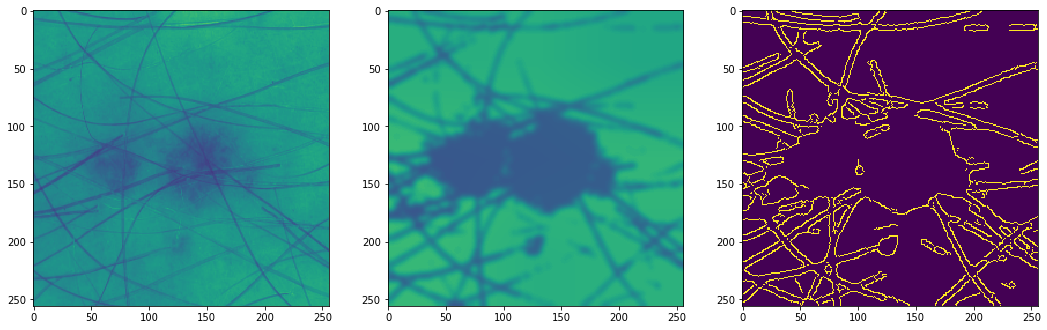

In [76]:
index = 96
img = nc_imgs[index]
img = np.uint8(img*255)
nani = cv2.GaussianBlur(img,(13,13),0)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
nani = clahe.apply(nani)

edges = cv2.Canny(nani,10,50)

fig, ax = plt.subplots(1,3,figsize=(18,6))

ax[0].imshow(nevus_imgs[index], vmax=255,vmin=0)
ax[1].imshow(nani, vmax=255,vmin=0)
ax[2].imshow(edges, vmax=255,vmin=0)


In [7]:
edge_imgs = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))

for img in nc_imgs:
    img = np.uint8(img*255)
    nani = cv2.GaussianBlur(img,(13,13),0)
    nani = clahe.apply(nani)
    edges = cv2.Canny(nani,10,50)
    edge_imgs += [edges]


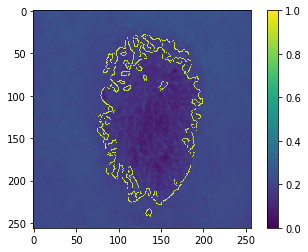

In [68]:
index = 90
img = nevus_imgs[index]

new_img = img/255  + edge_imgs[index]/255 + nc_imgs[index]/255

n_new_img = (new_img - np.min(new_img)) / (np.max(new_img) - np.min(new_img))

plt.imshow(n_new_img)
plt.colorbar()

In [9]:
new_imgs = []

for i in range(len(nevus_imgs)):
    new_img = nevus_imgs[i]/255  + edge_imgs[i]/255 + nc_imgs[i]/255
    n_new_img = (new_img - np.min(new_img)) / (np.max(new_img) - np.min(new_img))

    new_imgs += [n_new_img]

In [10]:
from hilbertcurve.hilbertcurve import HilbertCurve

def get_flat_coords(a):
    # Compute HilbertCurve for 256x256 img
    p=9; N=2
    hilbert_curve = HilbertCurve(p, N)
    flat_coords = []
    for ii in range(a**2):
        coords = hilbert_curve.coordinates_from_distance(ii)
    #     print(f'coords(h={ii}) = {coords}')
        flat_coords += [coords]
    flat_coords = np.array(flat_coords)
    return flat_coords

def hilbert_flat(img, flat_coords):
    flatten_image = []
    for x,y in flat_coords:
        flatten_image += [img[x,y]]

    return np.array(flatten_image)

In [82]:
'''
Flatten images with hilbert curve
'''
fc = get_flat_coords(256)
flat_imgs = [hilbert_flat(img,fc) for img in nevus_imgs]

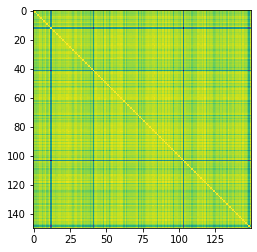

In [83]:
import pandas as pd
import scipy.spatial.distance as d

def euclidean_similarity(u,v):
    return 1/(1+d.euclidean(u,v))

def cosine_similarity(u,v):
    return d.cosine(u,v)

data = pd.DataFrame(np.array(flat_imgs))

dists = d.pdist(data, cosine_similarity)
sim = pd.DataFrame(d.squareform(dists), columns=data.index, index=data.index)

plt.imshow(sim)

In [84]:
from sklearn.cluster import SpectralCoclustering
model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(sim)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=2,
                     n_init=10, n_jobs=None, n_svd_vecs=None, random_state=0,
                     svd_method='randomized')

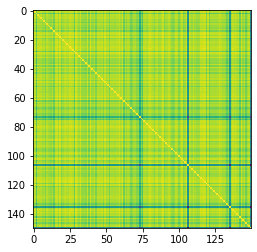

In [85]:
fit_data = np.array(sim)[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
plt.imshow(fit_data)

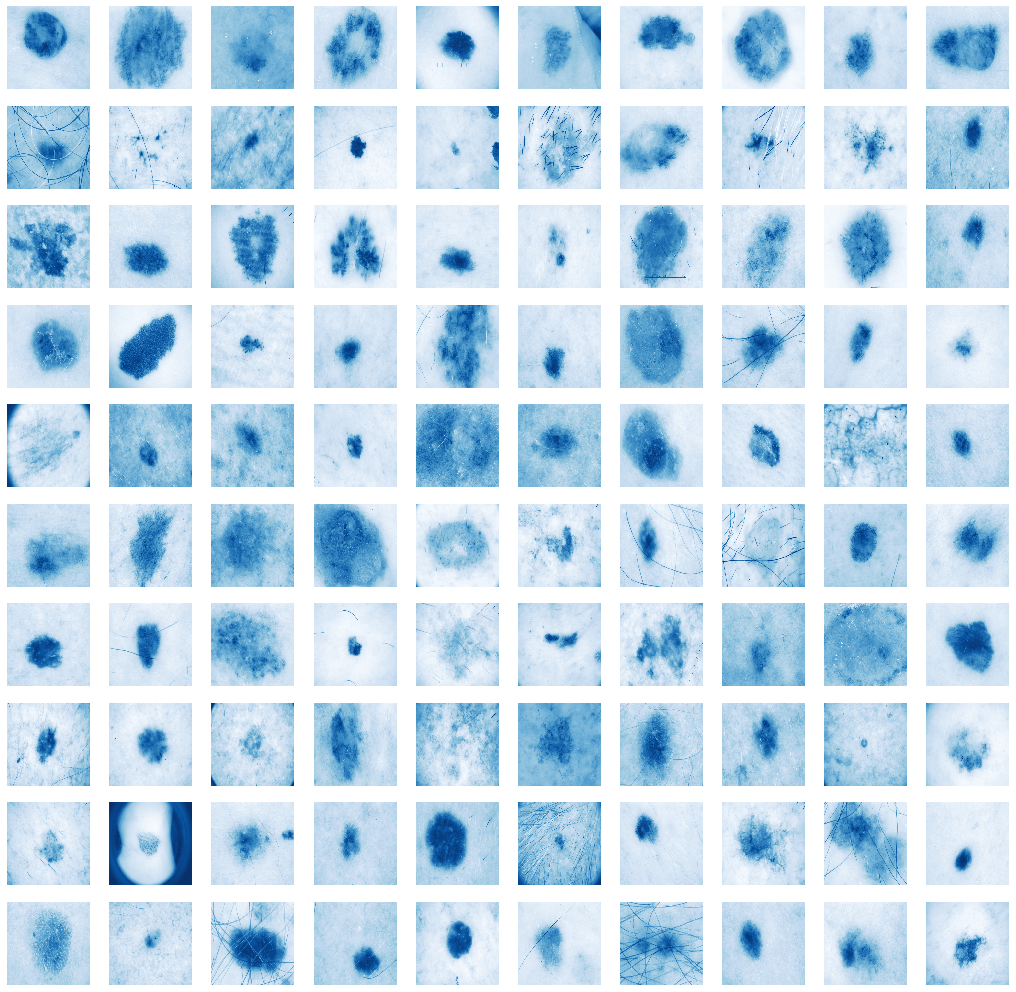

In [86]:
size = (10,10)

fig, ax = plt.subplots(size[0], size[1], figsize=(18,18))
k = 0
for x in range(size[0]):
    for y in range(size[1]):
        if model.row_labels_[k] == 0:
            ax[x,y].imshow(nevus_imgs[k], 'Blues_r')
        if model.row_labels_[k] == 1:
            ax[x,y].imshow(nevus_imgs[k], 'Greens_r')
        ax[x,y].axis('off')
        k+=1
 